In [12]:
# Machine Learning Engineer Nanodegree
## Capstone Project: Kickstarter Success Prediction
### Sujit Horakeri

#### In this project, I will build a binary classification model which will predict if a kickstarter campaign will be a success (1) or not (0) based on the project details.

## Data Exploration

In [99]:
# Import libraries needed
import pandas as pd
import numpy as np
import re
import datetime
from time import time
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# set pandas datafram display format to 3 floating point values
pd.set_option('display.float_format', lambda x: '%.4f' % x)

%matplotlib inline

In [14]:
# load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# keep a copy of the original data
o_train = train.copy()
o_test = test.copy()

In [15]:
# Check the dimensions of the train and test data
print('Train data dimensions: ', train.shape)
print('Test data dimensions: ', test.shape)

Train data dimensions:  (108129, 14)
Test data dimensions:  (63465, 12)


In [16]:
# Let's look at the head of the train data 
train.head()

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,backers_count,final_status
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,20.0000,drawing-for-dollars,False,US,USD,1241333999,1241334017,1240600507,1240602723,3,1
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",300.0000,sponsor-dereck-blackburn-lostwars-artist-in-re...,False,US,USD,1242429000,1242432018,1240960224,1240975592,2,0
2,kkst183622197,Mr. Squiggles,So I saw darkpony's successfully funded drawin...,30.0000,mr-squiggles,False,US,USD,1243027560,1243027818,1242163613,1242164398,0,0
3,kkst597742710,Help me write my second novel.,Do your part to help out starving artists and ...,500.0000,help-me-write-my-second-novel,False,US,USD,1243555740,1243556121,1240963795,1240966730,18,1
4,kkst1913131122,Support casting my sculpture in bronze,"I'm nearing completion on a sculpture, current...",2000.0000,support-casting-my-sculpture-in-bronze,False,US,USD,1243769880,1243770317,1241177914,1241180541,1,0


In [17]:
# Let's look at the head of the test data 
test.head()

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at
0,kkst917493670,Bràthair.,"My first film, of many to come. Trying to purs...",7000.0000,brathair,False,US,USD,1449619185,1449619185,1446002581,1446159585
1,kkst1664901914,THE SCREENWRITER,A young man that has earned his master's in sc...,35000.0000,the-screenwriter,False,US,USD,1453435620,1453435620,1450297323,1450411620
2,kkst925125077,The Hornets Nest the Fairmont Heights Story,Film about a high school constructed for negro...,49500.0000,the-hornets-nest-the-fairmont-heights-story,False,US,USD,1451780700,1451780700,1448581356,1448672128
3,kkst1427645275,BROTHERS Season 2 - Groundbreaking Transgender...,The acclaimed series about a group of transgen...,40000.0000,brothers-season-2-groundbreaking-transgender-male,False,US,USD,1445021518,1445021530,1440966830,1442429518
4,kkst1714249266,Blackdom the movie,Blackdom's history offers a new narrative tha...,20000.0000,blackdom-the-movie,False,US,USD,1462068840,1462068844,1455765276,1458334890


In [18]:
# Let's look at the columns and it's types of train data
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108129 entries, 0 to 108128
Data columns (total 14 columns):
project_id               108129 non-null object
name                     108126 non-null object
desc                     108120 non-null object
goal                     108129 non-null float64
keywords                 108129 non-null object
disable_communication    108129 non-null bool
country                  108129 non-null object
currency                 108129 non-null object
deadline                 108129 non-null int64
state_changed_at         108129 non-null int64
created_at               108129 non-null int64
launched_at              108129 non-null int64
backers_count            108129 non-null int64
final_status             108129 non-null int64
dtypes: bool(1), float64(1), int64(6), object(6)
memory usage: 10.8+ MB


None

In [19]:
# Let's look at the column and it's types of test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63465 entries, 0 to 63464
Data columns (total 12 columns):
project_id               63465 non-null object
name                     63465 non-null object
desc                     63461 non-null object
goal                     63465 non-null float64
keywords                 63465 non-null object
disable_communication    63465 non-null bool
country                  63465 non-null object
currency                 63465 non-null object
deadline                 63465 non-null int64
state_changed_at         63465 non-null int64
created_at               63465 non-null int64
launched_at              63465 non-null int64
dtypes: bool(1), float64(1), int64(4), object(6)
memory usage: 5.4+ MB


In [20]:
# Statistical summary of Train data
train.describe()

,goal,deadline,state_changed_at,created_at,launched_at,backers_count,final_status
count,108129.0000,108129.0000,108129.0000,108129.0000,108129.0000,108129.0000,108129.0000
mean,36726.2288,1380248498.0049,1380152995.7698,1374036857.7694,1377299004.7093,123.5167,0.3196
std,971902.7052,42702221.2209,42664018.4447,42723097.6779,42944212.6260,1176.7452,0.4663
min,0.0100,1241333999.0000,1241334017.0000,1240335335.0000,1240602723.0000,0.0000,0.0000
25%,2000.0000,1346732388.0000,1346695335.0000,1340057670.0000,1343917387.0000,2.0000,0.0000
50%,5000.0000,1393628400.0000,1393567218.0000,1384444520.0000,1390870008.0000,17.0000,0.0000
75%,13000.0000,1415719201.0000,1415547766.0000,1409622898.0000,1412807179.0000,65.0000,1.0000
max,100000000.0000,1433096938.0000,1433096940.0000,1432325200.0000,1432658473.0000,219382.0000,1.0000


In [21]:
# Statistical summary of Train data
test.describe()

,goal,deadline,state_changed_at,created_at,launched_at
count,63465.0000,63465.0000,63465.0000,63465.0000,63465.0000
mean,35323.7193,1459008907.9198,1458278292.7510,1451771216.3865,1456134610.4284
std,1206678.0607,16388498.2018,15712109.0084,19838269.1118,16419208.1925
min,1.0000,1433116800.0000,1428068650.0000,1266343242.0000,1427939719.0000
25%,2000.0000,1444521936.0000,1444418822.0000,1438097683.0000,1441755870.0000
50%,6000.0000,1458414817.0000,1458254471.0000,1452243288.0000,1455634804.0000
75%,20000.0000,1472586766.0000,1470671818.0000,1466366170.0000,1469649982.0000
max,100000000.0000,1490915735.0000,1490914927.0000,1490228268.0000,1490297448.0000


In [22]:
# Target variable distribution
train.final_status.value_counts()

0    73568
1    34561
Name: final_status, dtype: int64

In [23]:
# Find the number of null values in each columns of train data
train.isnull().sum()

project_id               0
name                     3
desc                     9
goal                     0
keywords                 0
disable_communication    0
country                  0
currency                 0
deadline                 0
state_changed_at         0
created_at               0
launched_at              0
backers_count            0
final_status             0
dtype: int64

In [24]:
# Find the number of null values in each columns of test data
test.isnull().sum()

project_id               0
name                     0
desc                     4
goal                     0
keywords                 0
disable_communication    0
country                  0
currency                 0
deadline                 0
state_changed_at         0
created_at               0
launched_at              0
dtype: int64

## Exploratory Data Analysis / Data Preprocessing

In [25]:
# Drop backers_count column as this is missing in the test data
train.drop(['backers_count'], axis=1, inplace=True)

#### It was evident that there were some missing text data in both the train and test dataset, let's replace the missing data with empty strings

In [26]:
# Handle missing data
train.fillna('', inplace=True)
test.fillna('', inplace=True)

#### From the statistics summary we could guess that there is a possibility of outliers in the 'goal' column, let's visualize and confirm the same

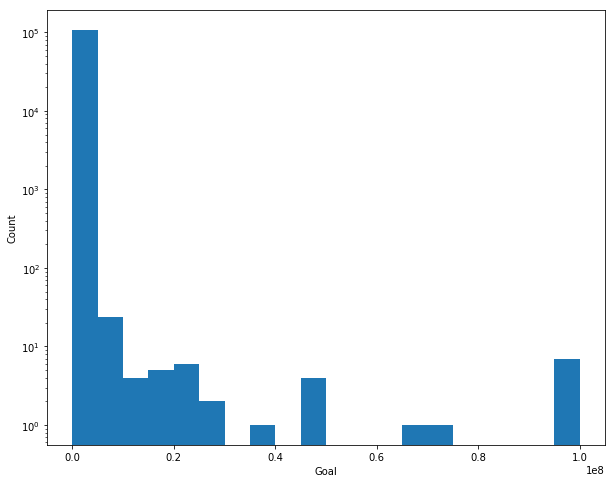

In [27]:
# Detect outliers
plt.hist(train.goal, bins=20, log=True)
plt.xlabel('Goal')
plt.ylabel('Count')
plt.gcf().set_size_inches(10,8)
plt.show()

In [28]:
# Log transform Goal feature to get rid of skewness
train['goal'] = np.log1p(train.goal)
test['goal'] = np.log1p(test.goal)

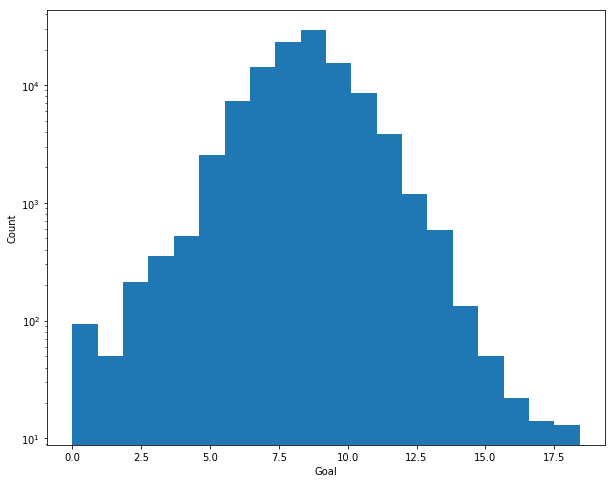

In [29]:
# Plot the histogram again
plt.hist(train.goal, bins=20, log=True)
plt.xlabel('Goal')
plt.ylabel('Count')
plt.gcf().set_size_inches(10,8)
plt.show()

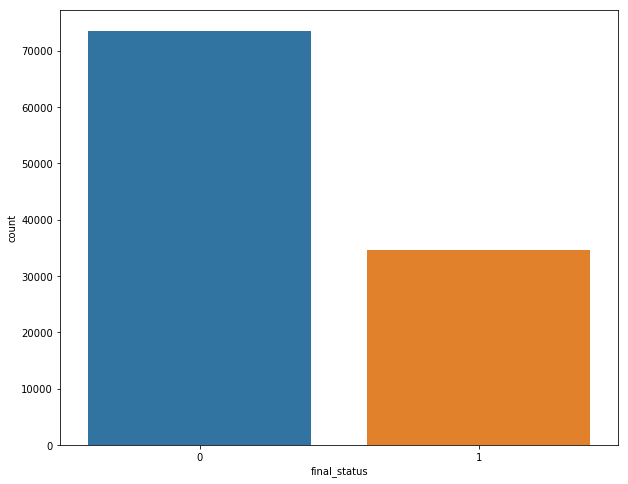

In [30]:
# Visualize target variable counts
sns.countplot(x= 'final_status',data=train)
plt.gcf().set_size_inches(10,8)

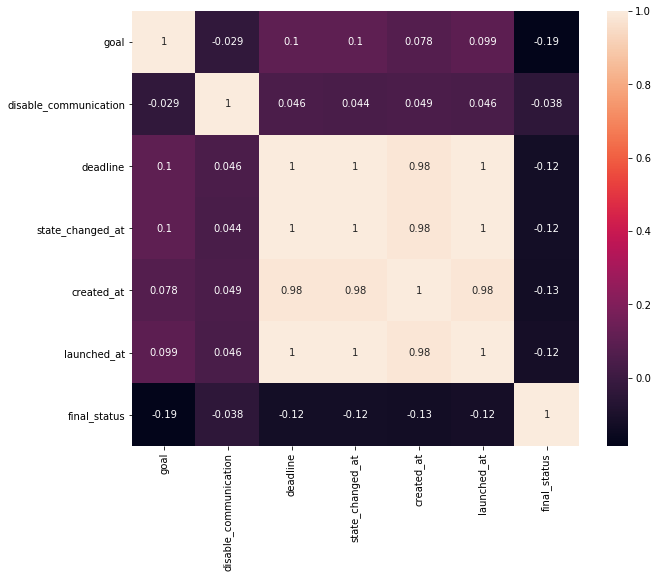

In [31]:
# Let us check the correleation between the variables
sns.heatmap(train.corr(),annot=True) 
plt.gcf().set_size_inches(10,8)

#### There seems to be a complete correlation between deadline, state_changed_at and launched_at, we could decide to drop two of the columns in case we end up with more features than the training sample size. But, in this case we have quite a large training dataset and hence we decide to keep the variables.

#### There aren't any heavily correlated features to the target variable and hence one thing is pretty clear that we cannot use a linear regression model here

In [32]:
# Find non-numeric variables
list(set(train.columns) - set(train._get_numeric_data().columns))

['currency', 'keywords', 'name', 'project_id', 'country', 'desc']

In [33]:
# Categorical variables
cat_cols = ['currency', 'country']

# text variables
text_cols = ['keywords', 'desc', 'name']

# bool variables
bool_cols = list(set(train._get_bool_data().columns))
print(bool_cols)

['disable_communication']


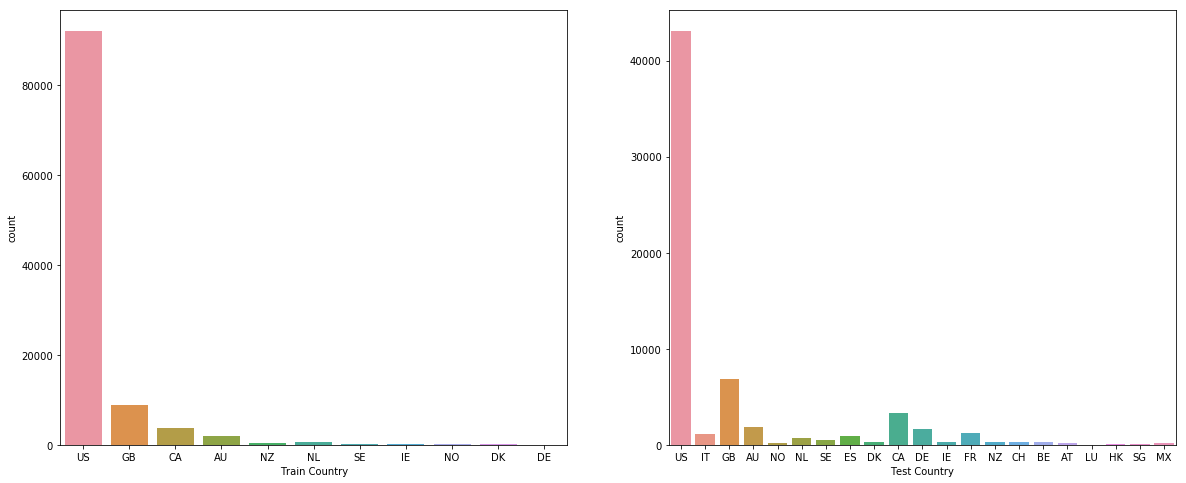

In [34]:
# visualize country counts
fig, ax =plt.subplots(1,2)
sns.countplot('country', data=train, ax=ax[0])
ax[0].set(xlabel='Train Country')
sns.countplot('country', data=test, ax=ax[1])
ax[1].set(xlabel='Test Country')
plt.gcf().set_size_inches(20,8)

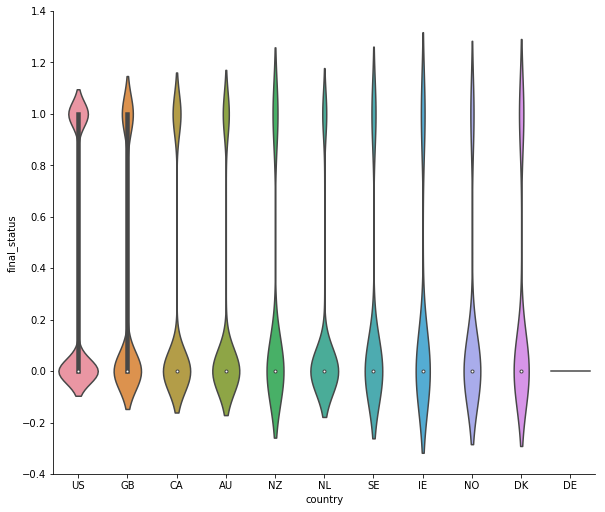

In [35]:
# Visualize how does country affect final_status
sns.factorplot(x="country", y="final_status", data=train, kind="violin")
plt.gcf().set_size_inches(10,8)

#### It is clear that the data is imbalanced and there are unsuccessful kickstarter projects than successful, regardless of the country they are from. One thing to note is that the projects from DE are not successful at all. But, there are very little samples for DE and hence nothing can be concluded.

#### It might also make sense to drop the rows with DE as country since our model might misinterpret this data.

In [36]:
# Find the missing countries in train data that are present in test 
list(set(test.country) - set(train.country))

['IT', 'CH', 'BE', 'FR', 'LU', 'ES', 'SG', 'MX', 'AT', 'HK']

In [37]:
test.shape

(63465, 12)

In [38]:
test[test['country'].isin(['HK', 'ES', 'LU', 'BE', 'FR', 'SG', 'MX', 'IT', 'AT', 'CH'])]['name'].count()

4465

#### In the test dataset there are too many rows with new unseen countries as far as train dataset is concerned and hence it is not a good idea to have any feature engineered wrt the final_status.


disable_communication  final_status
False                  0               73245
                       1               34561
True                   0                 323
Name: final_status, dtype: int64


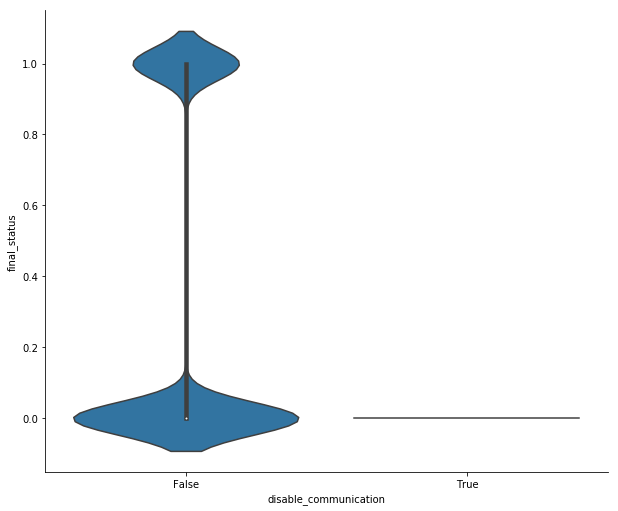

In [39]:
# Check out how varibale disable_communication affects final_status
print(train.groupby('disable_communication').final_status.value_counts())

# Visualize how does disable_communication affect final_status
sns.factorplot(x="disable_communication", y="final_status", data=train, kind="violin")
plt.gcf().set_size_inches(10,8)

#### From the above observation, it is clear that when the disable_communication flag is set to true, the final_status is 0. But there are only 0.3% (323) such values. It is worth checking the change in f1 score by dropping these rows.

In [40]:
# convert unix time format
unix_cols = ['deadline','state_changed_at','launched_at','created_at']

for x in unix_cols:
    train[x+'_date'] = train[x].apply(lambda k: datetime.datetime.fromtimestamp(int(k)).strftime('%Y-%m-%d %H:%M:%S'))
    test[x+'_date'] = test[x].apply(lambda k: datetime.datetime.fromtimestamp(int(k)).strftime('%Y-%m-%d %H:%M:%S'))


In [41]:
# Create features early campaign duration and campaign duration
train['early_campaign_duration'] = ((train['launched_at'] - train['created_at'])).astype(int)
test['early_campaign_duration'] = ((test['launched_at'] - test['created_at'])).astype(int)
train['campaign_duration'] = ((train['deadline'] - train['launched_at'])).astype(int)
test['campaign_duration'] = ((test['deadline'] - test['launched_at'])).astype(int)

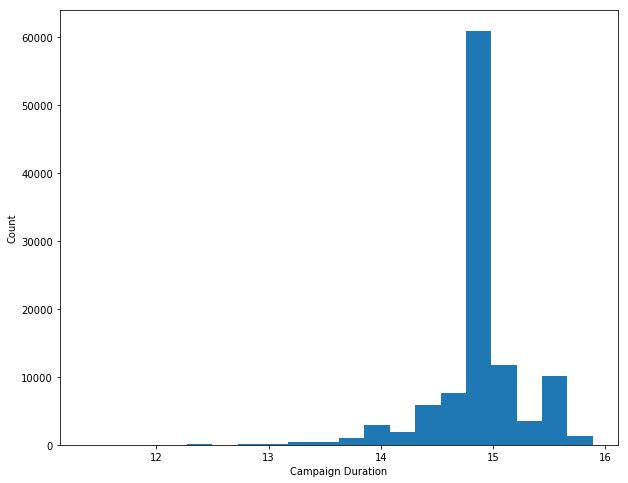

In [42]:
# Check the distribution
plt.hist(np.log1p(train.campaign_duration), bins=20)
plt.xlabel('Campaign Duration')
plt.ylabel('Count')
plt.gcf().set_size_inches(10,8)
plt.show()

In [43]:
# Create feature for cancelled kickstarters
train['cancelled'] = np.where(pd.to_datetime(train['deadline']) > pd.to_datetime(train['state_changed_at']), 1, 0)
test['cancelled'] = np.where(pd.to_datetime(test['deadline']) > pd.to_datetime(test['state_changed_at']), 1, 0)

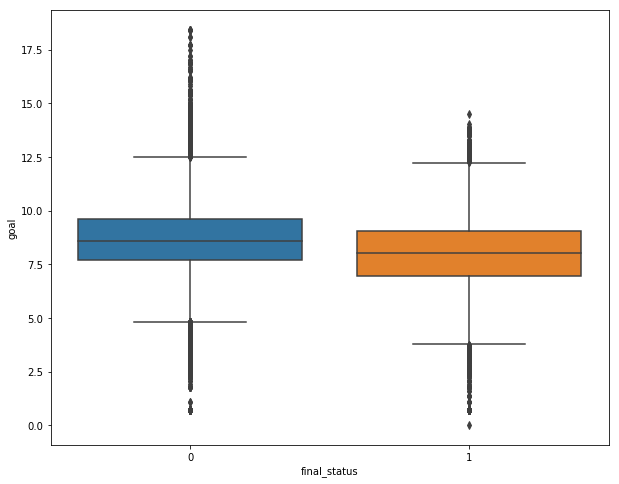

In [44]:
# visualize how goal affects final_status
sns.boxplot('final_status', 'goal', data=train)
plt.gcf().set_size_inches(10,8)

In [45]:
# Create feature for the goal per day during the campaign
train['goal_per_day'] = ((np.expm1(train['goal']) / (train['campaign_duration']/86400)))
test['goal_per_day'] = ((np.expm1(test['goal']) / (test['campaign_duration']/86400)))

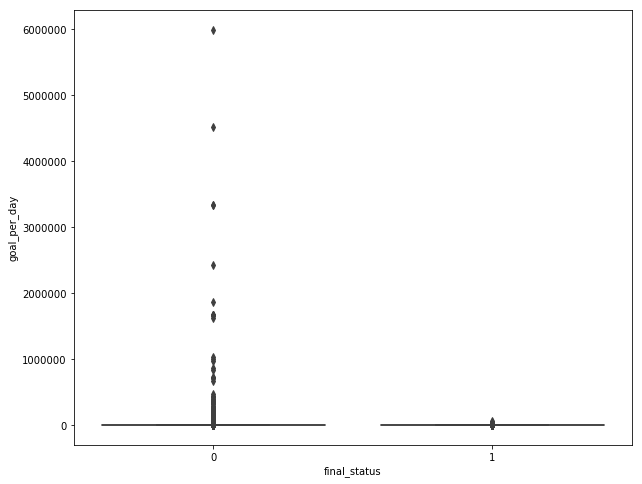

In [46]:
# visualize how goal affects final_status
sns.boxplot('final_status', 'goal_per_day', data=train)
plt.gcf().set_size_inches(10,8)

In [47]:
# Log transform goal_per_day feature
train['goal_per_day'] = np.log1p(train.goal_per_day)
test['goal_per_day'] = np.log1p(test.goal_per_day)

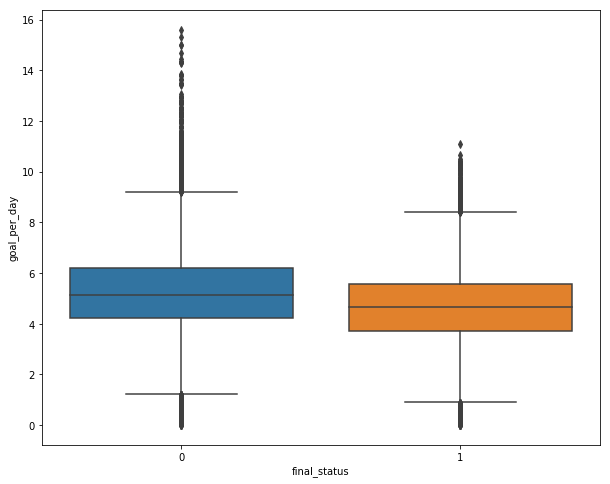

In [48]:
# visualize how goal affects final_status again after log transforming goal_per_day
sns.boxplot('final_status', 'goal_per_day', data=train)
plt.gcf().set_size_inches(10,8)

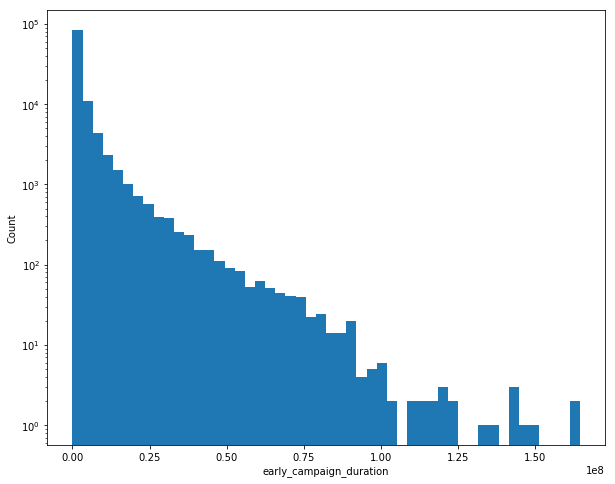

In [49]:
# Plot the histogram of early_campaign_duration
plt.hist(train.early_campaign_duration, bins=50, log=True)
plt.xlabel('early_campaign_duration')
plt.ylabel('Count')
plt.gcf().set_size_inches(10,8)
plt.show()

In [50]:
# Log transform skewed early_campaign_duration feature
train['early_campaign_duration'] = np.log1p(train.early_campaign_duration)
test['early_campaign_duration'] = np.log1p(test.early_campaign_duration)

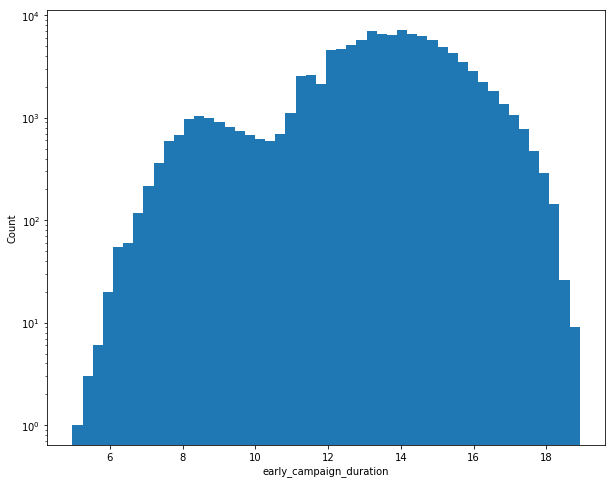

In [51]:
# Plot the histogram again
plt.hist(train.early_campaign_duration, bins=50, log=True)
plt.xlabel('early_campaign_duration')
plt.ylabel('Count')
plt.gcf().set_size_inches(10,8)
plt.show()

In [52]:
# Generate Weekday and Weekday-Country features from all the time features - train
time_cols = ['deadline', 'created_at', 'launched_at',  'state_changed_at']
for time in time_cols:
    weekday = []
    hour = []
    day = []
    for x in train.loc[:, time].tolist():
        weekday += [datetime.datetime.fromtimestamp(x).weekday()]
        hour += [datetime.datetime.fromtimestamp(x).hour]
        day += [datetime.datetime.fromtimestamp(x).day]
    train[time + '_' + 'weekday'] = weekday
    train[time + '_' + 'hour'] = hour
    train[time + '_' + 'day'] = day
    
for time in time_cols:
    train[time + '_' + 'hour_weekday'] = train[time + '_' + 'hour'].astype(str) + '_' + train[time + '_' + 'weekday'].astype(str)
    train[time + '_' + 'hour_country'] = train[time + '_' + 'hour'].astype(str) + '_' + train['country'].astype(str)
    train[time + '_' + 'weekday_country'] = train[time + '_' + 'weekday'].astype(str) + '_' + train['country'].astype(str)
    train[time + '_' + 'day_country'] = train[time + '_' + 'day'].astype(str) + '_' + train['country'].astype(str)

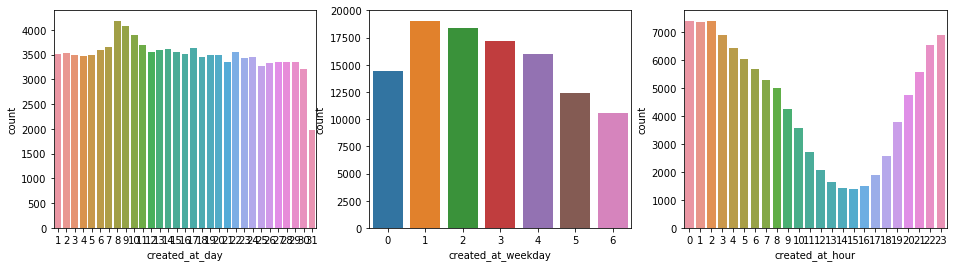

In [53]:
# visualize how the number of projects' created_at vary
fig, ax =plt.subplots(1,3)
sns.countplot('created_at_day', data=train, ax=ax[0])
sns.countplot('created_at_weekday', data=train, ax=ax[1])
sns.countplot('created_at_hour', data=train, ax=ax[2])
plt.gcf().set_size_inches(16,4)

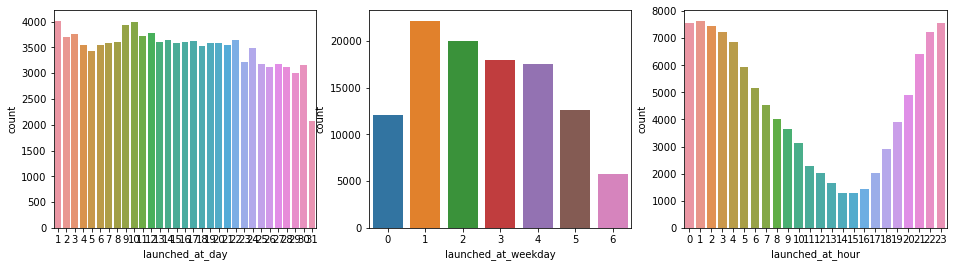

In [54]:
# visualize how the number of projects' launched_at vary
fig, ax =plt.subplots(1,3)
sns.countplot('launched_at_day', data=train, ax=ax[0])
sns.countplot('launched_at_weekday', data=train, ax=ax[1])
sns.countplot('launched_at_hour', data=train, ax=ax[2])
plt.gcf().set_size_inches(16,4)

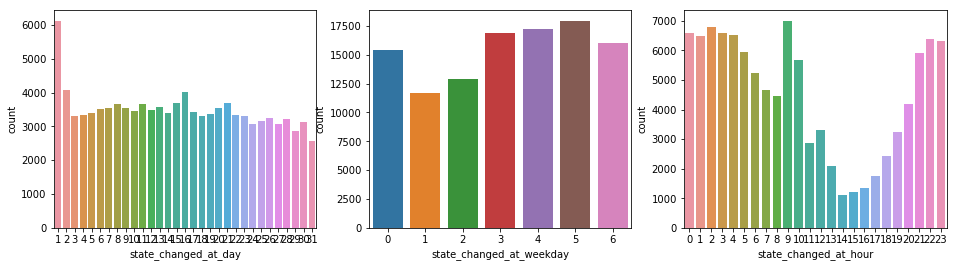

In [55]:
# visualize how the number of projects' state_changed_at vary
fig, ax =plt.subplots(1,3)
sns.countplot('state_changed_at_day', data=train, ax=ax[0])
sns.countplot('state_changed_at_weekday', data=train, ax=ax[1])
sns.countplot('state_changed_at_hour', data=train, ax=ax[2])
plt.gcf().set_size_inches(16,4)

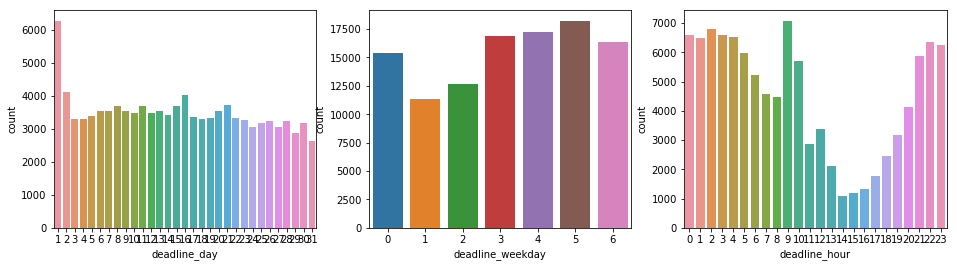

In [56]:
# visualize how the number of projects' dealine vary
fig, ax =plt.subplots(1,3)
sns.countplot('deadline_day', data=train, ax=ax[0])
sns.countplot('deadline_weekday', data=train, ax=ax[1])
sns.countplot('deadline_hour', data=train, ax=ax[2])
plt.gcf().set_size_inches(16,4)

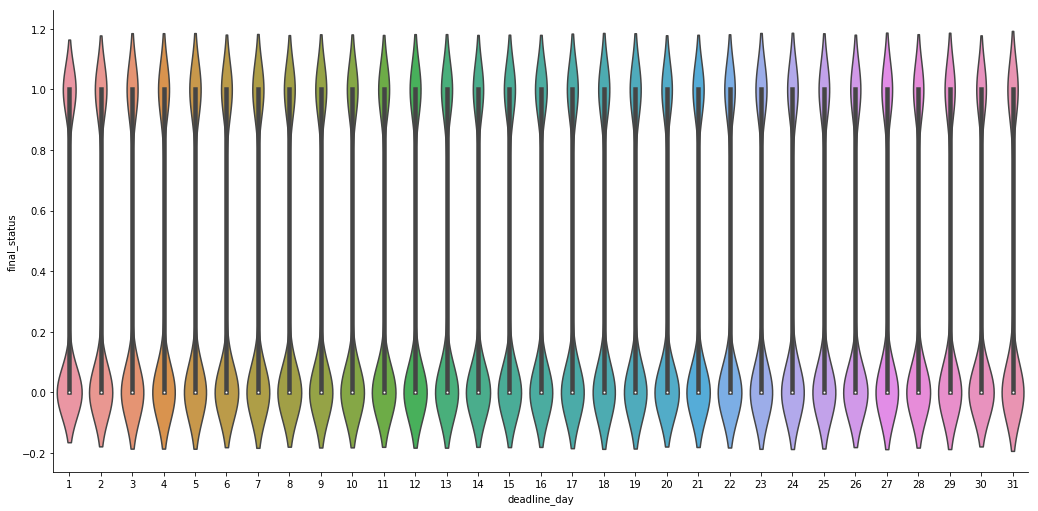

In [57]:
# Visualize how does deadline_day affect final_status
sns.factorplot(x="deadline_day", y="final_status", data=train, kind="violin")
plt.gcf().set_size_inches(18,8)

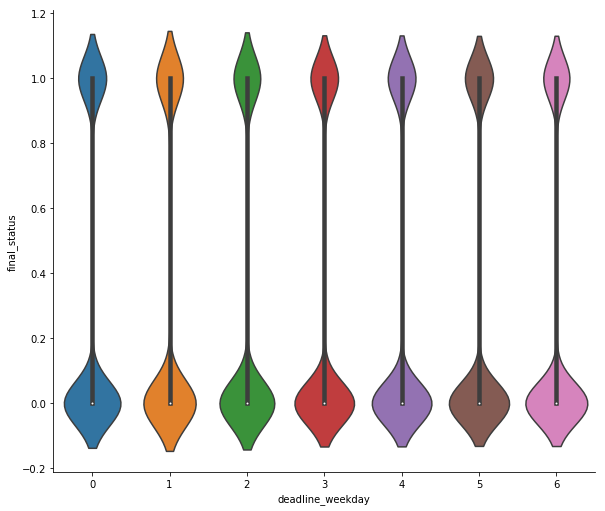

In [58]:
# Visualize how does deadline_weekday affect final_status
sns.factorplot(x="deadline_weekday", y="final_status", data=train, kind="violin")
plt.gcf().set_size_inches(10,8)

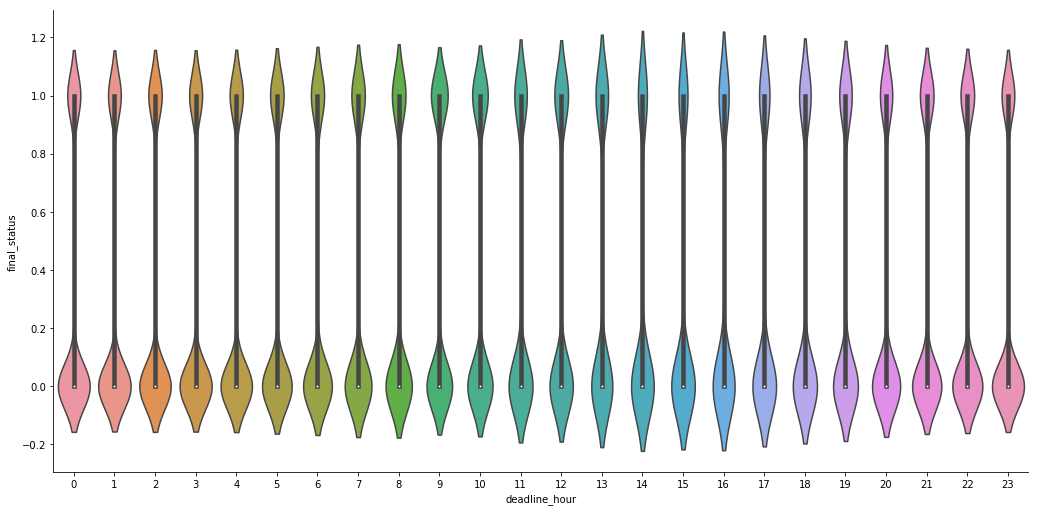

In [59]:
# Visualize how does deadline_hour affect final_status
sns.factorplot(x="deadline_hour", y="final_status", data=train, kind="violin")
plt.gcf().set_size_inches(18,8)

#### There seems to be a clear trend in the time, day of week and date of month, adding these features might benefit the model

In [60]:
# Generate Weekday and Weekday-Country features from all time features - test
time_cols = ['deadline', 'created_at', 'launched_at',  'state_changed_at']
for time in time_cols:
    weekday = []
    hour = []
    day = []
    for x in test.loc[:, time].tolist():
        weekday += [datetime.datetime.fromtimestamp(x).weekday()]
        hour += [datetime.datetime.fromtimestamp(x).hour]
        day += [datetime.datetime.fromtimestamp(x).day]
    test[time + '_' + 'weekday'] = weekday
    test[time + '_' + 'hour'] = hour
    test[time + '_' + 'day'] = day
    
for time in time_cols:
    test[time + '_' + 'hour_weekday'] = test[time + '_' + 'hour'].astype(str) + '_' + test[time + '_' + 'weekday'].astype(str)
    test[time + '_' + 'hour_country'] = test[time + '_' + 'hour'].astype(str) + '_' + test['country'].astype(str)
    test[time + '_' + 'weekday_country'] = test[time + '_' + 'weekday'].astype(str) + '_' + test['country'].astype(str)
    test[time + '_' + 'day_country'] = test[time + '_' + 'day'].astype(str) + '_' + test['country'].astype(str)

### Text features

In [61]:
train.shape

(108129, 49)

In [62]:
# Replace - with space in keywords column
train['keywords'] = train['keywords'].str.replace('-',' ')
test['keywords'] = test['keywords'].str.replace('-',' ')

In [63]:
# create new feature from concatenation of all text columns
train['all_text'] = train['name'] + " "+ train['desc'] +" "+ train['keywords']
test['all_text'] = test['name'] + " "+ test['desc'] +" "+ test['keywords']

In [64]:
# all text columns
text_cols = ['name', 'desc', 'keywords', 'all_text']
for col in text_cols:
    train[col+'_len'] = train[col].str.len()
    train[col+'_count'] = train[col].str.split().str.len()
    test[col+'_len'] = test[col].str.len()
    test[col+'_count'] = test[col].str.split().str.len()

In [65]:
display(train[['name_count','desc_count','keywords_count', 'all_text_count']].describe())

,name_count,desc_count,keywords_count,all_text_count
count,108129.0000,108129.0000,108129.0000,108129.0000
mean,5.6886,19.5180,5.4261,30.6327
std,2.7666,4.8977,2.5192,7.6607
min,0.0000,0.0000,1.0000,3.0000
25%,3.0000,17.0000,3.0000,26.0000
50%,5.0000,20.0000,5.0000,31.0000
75%,8.0000,23.0000,7.0000,36.0000
max,27.0000,35.0000,25.0000,77.0000


In [66]:
display(train[['name_len','desc_len','keywords_len', 'all_text_len']].describe())

,name_len,desc_len,keywords_len,all_text_len
count,108129.0000,108129.0000,108129.0000,108129.0000
mean,51.6716,133.9949,31.6551,219.3217
std,68.7189,79.3774,13.7262,121.8186
min,0.0000,0.0000,1.0000,13.0000
25%,21.0000,106.0000,20.0000,159.0000
50%,35.0000,126.0000,31.0000,190.0000
75%,51.0000,133.0000,45.0000,229.0000
max,1076.0000,1268.0000,115.0000,2268.0000


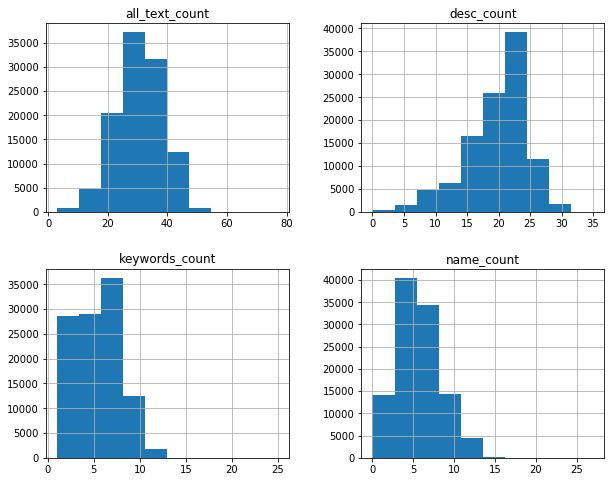

In [67]:
# visualize the histogram of word count columns
train[['name_count','desc_count','keywords_count', 'all_text_count']].hist(bins=10)
plt.gcf().set_size_inches(10,8)

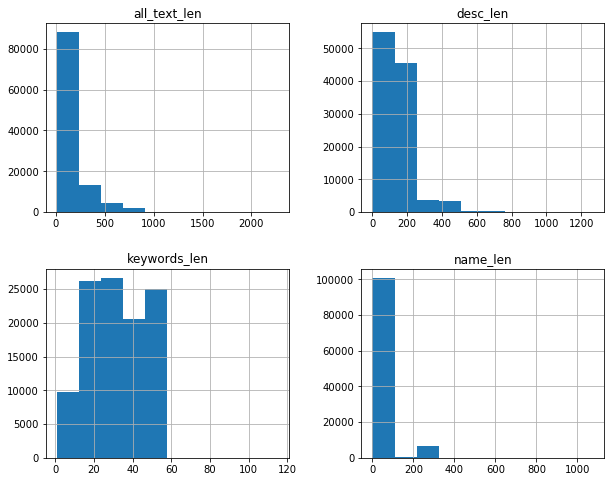

In [68]:
# visualize the histogram of character length columns
train[['name_len','desc_len','keywords_len', 'all_text_len']].hist(bins=10)
plt.gcf().set_size_inches(10,8)

In [69]:
# creating a Series from train and test for text columns
kick_desc = pd.Series(train['desc'].tolist() + test['desc'].tolist()).astype(str)
kick_name = pd.Series(train['name'].tolist() + test['name'].tolist()).astype(str)
kick_keywords = pd.Series(train['keywords'].tolist() + test['keywords'].tolist()).astype(str)

In [70]:
# this function cleans punctuations, digits and irregular tabs. Then converts the sentences to lower
def sentence_clean(word):
    p1 = re.sub(pattern='(\W+)|(\d+)|(\s+)',repl=' ',string=word)
    p1 = p1.lower()
    return p1

In [71]:
# instantiate snowballstemmer
stemmer = SnowballStemmer(language='english')

In [72]:
# clean descriptions
kick_desc = kick_desc.map(sentence_clean)
# split words
kick_desc = [[x for x in x.split()] for x in kick_desc]
# apply stemming
kick_desc = [[stemmer.stem(x) for x in x] for x in kick_desc]
# ignore words with less than Three characters
kick_desc = [[x for x in x if len(x) > 2] for x in kick_desc]
# join the words with space separation
kick_desc = [' '.join(x) for x in kick_desc]

In [73]:
# apply the above steps for name 
kick_name = kick_name.map(sentence_clean)
kick_name = [[x for x in x.split() ] for x in kick_name]
kick_name = [[stemmer.stem(x) for x in x] for x in kick_name]
kick_name = [[x for x in x if len(x) > 2] for x in kick_name]
kick_name = [' '.join(x) for x in kick_name]

In [74]:
# apply the above steps for keywords
kick_keywords = kick_keywords.map(sentence_clean)
kick_keywords = [[x for x in x.split()] for x in kick_keywords]
kick_keywords = [[stemmer.stem(x) for x in x] for x in kick_keywords]
kick_keywords = [[x for x in x if len(x) > 2] for x in kick_keywords]
kick_keywords = [' '.join(x) for x in kick_keywords]

In [75]:
# instantiate TfidfVectorizer for each of name, desc and keywords
tfidf_desc = TfidfVectorizer(max_features=400, ngram_range=(1,4), stop_words='english')
tfidf_name = TfidfVectorizer(max_features=150, ngram_range=(1,2), stop_words='english')
tfidf_keywords = TfidfVectorizer(max_features=250, ngram_range=(1,3), stop_words='english')

In [76]:
# fit_transform to each of the above dataframes
all_desc = tfidf_desc.fit_transform(kick_desc).todense()
all_name = tfidf_name.fit_transform(kick_name).todense()
all_keywords = tfidf_keywords.fit_transform(kick_keywords).todense()
# delete kick_desc, kick_name, kick_keywords
del kick_desc, kick_name, kick_keywords

In [77]:
# convert to dataframes
all_desc_df = pd.DataFrame(all_desc)
all_name_df = pd.DataFrame(all_name)
all_keywords_df = pd.DataFrame(all_keywords)
# rename variables
all_desc_df.rename(columns= lambda x: 'variable_desc_'+ str(x), inplace=True)
all_name_df.rename(columns= lambda x: 'variable_name_'+ str(x), inplace=True)
all_keywords_df.rename(columns= lambda x: 'variable_keywords_'+ str(x), inplace=True)

In [78]:
del all_desc, all_name, all_keywords

In [79]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [80]:
# top Ten words in desc
top_tfidf_feats(tfidf_desc.idf_, tfidf_desc.get_feature_names(), 10)

,feature,tfidf
0,car,6.3279
1,farm,6.3243
2,wood,6.2960
3,camera,6.2925
4,beer,6.2833
5,die,6.2810
6,deck,6.2775
7,hip hop,6.2684
8,press,6.2639
9,user,6.2628


In [81]:
# top Ten words in name
top_tfidf_feats(tfidf_name.idf_, tfidf_name.get_feature_names(), 10)

,feature,tfidf
0,women,6.7178
1,zombi,6.6864
2,graphic,6.6779
3,organ,6.6779
4,iphon,6.6728
5,photographi,6.6711
6,apparel,6.6643
7,real,6.6526
8,school,6.6444
9,danc,6.6427


In [82]:
# top Ten words in keywords
top_tfidf_feats(tfidf_keywords.idf_, tfidf_keywords.get_feature_names(), 10)

,feature,tfidf
0,stand,7.1367
1,sport,7.1233
2,beer,7.1233
3,dragon,7.1206
4,scienc,7.1101
5,word,7.1101
6,portrait,7.1049
7,meet,7.1049
8,green,7.1022
9,car,7.0971


In [83]:
# concat all the above Three dataframes and delete them once combined
combine = pd.concat([all_desc_df, all_name_df, all_keywords_df],axis=1)
del all_desc_df, all_name_df, all_keywords_df

In [84]:
# check the shape the combined dataframe
combine.shape

(171594, 800)

### Label Encode Categorical Variables

In [85]:
train.columns

Index(['project_id', 'name', 'desc', 'goal', 'keywords',
       'disable_communication', 'country', 'currency', 'deadline',
       'state_changed_at', 'created_at', 'launched_at', 'final_status',
       'deadline_date', 'state_changed_at_date', 'launched_at_date',
       'created_at_date', 'early_campaign_duration', 'campaign_duration',
       'cancelled', 'goal_per_day', 'deadline_weekday', 'deadline_hour',
       'deadline_day', 'created_at_weekday', 'created_at_hour',
       'created_at_day', 'launched_at_weekday', 'launched_at_hour',
       'launched_at_day', 'state_changed_at_weekday', 'state_changed_at_hour',
       'state_changed_at_day', 'deadline_hour_weekday',
       'deadline_hour_country', 'deadline_weekday_country',
       'deadline_day_country', 'created_at_hour_weekday',
       'created_at_hour_country', 'created_at_weekday_country',
       'created_at_day_country', 'launched_at_hour_weekday',
       'launched_at_hour_country', 'launched_at_weekday_country',
       'laun

In [86]:
# label encode categorical features
cat_feat = ['currency','country', 'deadline_hour_country', 'deadline_weekday_country', 'deadline_day_country', 'created_at_hour_country',
'created_at_weekday_country', 'created_at_day_country', 'launched_at_hour_country', 'launched_at_weekday_country',
'launched_at_day_country', 'state_changed_at_hour_country', 'state_changed_at_weekday_country', 'state_changed_at_day_country']

for x in cat_feat:
    le = LabelEncoder()
    le.fit(list(train[x].values) + list(test[x].values))
    train[x] = le.transform(list(train[x]))
    test[x] = le.transform(list(test[x]))

In [87]:
#split the text features
train_text = combine[:train.shape[0]]
test_text = combine[train.shape[0]:]
test_text.reset_index(drop=True,inplace=True)

### Finalizing train and test data before merging

In [88]:
train.columns.values

array(['project_id', 'name', 'desc', 'goal', 'keywords',
       'disable_communication', 'country', 'currency', 'deadline',
       'state_changed_at', 'created_at', 'launched_at', 'final_status',
       'deadline_date', 'state_changed_at_date', 'launched_at_date',
       'created_at_date', 'early_campaign_duration', 'campaign_duration',
       'cancelled', 'goal_per_day', 'deadline_weekday', 'deadline_hour',
       'deadline_day', 'created_at_weekday', 'created_at_hour',
       'created_at_day', 'launched_at_weekday', 'launched_at_hour',
       'launched_at_day', 'state_changed_at_weekday',
       'state_changed_at_hour', 'state_changed_at_day',
       'deadline_hour_weekday', 'deadline_hour_country',
       'deadline_weekday_country', 'deadline_day_country',
       'created_at_hour_weekday', 'created_at_hour_country',
       'created_at_weekday_country', 'created_at_day_country',
       'launched_at_hour_weekday', 'launched_at_hour_country',
       'launched_at_weekday_country', 'laun

In [89]:
cols_to_use = ['disable_communication', 'country', 'deadline', 'goal',
       'state_changed_at', 'created_at', 'launched_at', 
       'early_campaign_duration', 'campaign_duration',
       'cancelled', 'goal_per_day', 'name_len', 'name_count', 'desc_len', 'desc_count',
       'keywords_len', 'keywords_count', 'all_text_len', 'all_text_count', 'deadline_weekday',
       'deadline_hour', 'deadline_day', 'created_at_weekday',
       'created_at_hour', 'created_at_day', 'launched_at_weekday',
       'launched_at_hour', 'launched_at_day', 'state_changed_at_weekday',
       'state_changed_at_hour', 'state_changed_at_day',
       'deadline_hour_weekday', 'deadline_hour_country',
       'deadline_weekday_country', 'deadline_day_country',
       'created_at_hour_weekday', 'created_at_hour_country',
       'created_at_weekday_country', 'created_at_day_country',
       'launched_at_hour_weekday', 'launched_at_hour_country',
       'launched_at_weekday_country', 'launched_at_day_country',
       'state_changed_at_hour_weekday', 'state_changed_at_hour_country',
       'state_changed_at_weekday_country', 'state_changed_at_day_country']

In [90]:
target = train['final_status']

In [91]:
# Normalize numerical features
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['deadline', 'goal',
       'early_campaign_duration', 'campaign_duration', 'goal_per_day', 'name_len', 'name_count', 'desc_len', 'desc_count',
       'keywords_len', 'keywords_count', 'all_text_len', 'all_text_count']

train[numerical] = scaler.fit_transform(train[numerical])
test[numerical] = scaler.fit_transform(test[numerical])

In [92]:
# filter unused columns
train_filtered = train.loc[:,cols_to_use]
test_filtered = test.loc[:,cols_to_use]

# concat tfidf features
train_df = pd.concat([train_filtered, train_text],axis=1)
test_df = pd.concat([test_filtered, test_text],axis=1)
del train_text, test_text
train_df = train_df.groupby(train_df.columns, axis=1).sum()
test_df = test_df.groupby(test_df.columns, axis=1).sum()

In [93]:
print ('Train shape: ', train_df.shape)
print ('Test shape: ', test_df.shape)

Train shape:  (108129, 847)
Test shape:  (63465, 847)


### Naive Predictor

#### A naive predictor is where we could simply predict that all the projects get successful. Let's see what is the accuracy score and fscore for the same.

In [125]:
naive_preds = pd.Series(1, index=np.arange(len(train_df)))

In [126]:
TP_naive = np.sum(target) 
FP_naive = target.count() - TP_naive 
TN_naive = 0 
FN_naive = 0 

accuracy = (TP_naive + TN_naive)/(TP_naive + TN_naive + FP_naive + FN_naive)
recall = TP_naive / (TP_naive + FN_naive)
precision = TP_naive / (TP_naive + FP_naive)

beta = 0.5
fscore = (1+ beta**2)* precision * recall/(precision*(beta**2) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.3196, F-score: 0.3700]


### Shuffle and Split Data

In [94]:
from sklearn.model_selection import train_test_split

# Split the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_df, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 77)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 86503 samples.
Testing set has 21626 samples.


### Train Model And Predict 

In [95]:
from sklearn.metrics import accuracy_score, fbeta_score
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # Get start time
    learner.fit(X_train, y_train)
    end = time() # Get end time
    
    results['train_time'] = end - start
        
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    results['pred_time'] = end - start
    results['acc_train'] = accuracy_score(y_train, predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['f_train'] = fbeta_score(y_train, predictions_train, beta=0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained".format(learner.__class__.__name__))
    print("Results: {}".format(results))
        
    # Return the results
    return results

### Benchmark Model

#### Random Forest

In [105]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_jobs=-1, random_state=77)

results_rf_clf = train_predict(rf_clf, X_train, y_train, X_test, y_test)

RandomForestClassifier trained
Results: {'train_time': 10.61050009727478, 'pred_time': 6.6143999099731445, 'acc_train': 0.9804168641550004, 'acc_test': 0.69157495607139552, 'f_train': 0.98592670665220916, 'f_test': 0.42925026399155231}


#### Hyperparameter Tuning 

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer 
def kFoldCV(clf, X_train, y_train, X_test, y_test, parameters, cv_sets):
    grid_obj = GridSearchCV(clf, parameters, n_jobs=-1, cv=cv_sets, verbose=10, 
                            scoring = make_scorer(fbeta_score, beta=0.5))
    grid_fit = grid_obj.fit(X_train, y_train)
    best_clf = grid_fit.best_estimator_
    best_score = grid_fit.best_score_
    print('best model: ', best_clf)
    best_predictions = best_clf.predict(X_test)
    
    results_cv = {}
   
    best_predictions_train = best_clf.predict(X_train)
    best_predictions_test = best_clf.predict(X_test)
   
    results_cv['best_clf'] = grid_fit.best_estimator_
    results_cv['best_acc_train'] = accuracy_score(y_train, best_predictions_train)
    results_cv['best_acc_test'] = accuracy_score(y_test, best_predictions_test)
    results_cv['best_f_train'] = fbeta_score(y_train, best_predictions_train, beta=0.5)
    results_cv['best_f_test'] = fbeta_score(y_test, best_predictions_test, beta=0.5)
    
    return results_cv

In [108]:
params = {'n_estimators': [10, 100],  'min_samples_split' : [2, 5, 10], 'min_samples_leaf' : [1, 2, 4]}

cv_sets = ShuffleSplit(n_splits=3, test_size = 0.20, random_state = 77)

model1 = RandomForestClassifier(n_jobs=-1, random_state=77)

results_cv_rf = kFoldCV(model1, X_train, y_train, X_test, y_test, params, cv_sets)
print('CV results: ', results_cv_rf)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 19.6min finished


best model:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=77, verbose=0, warm_start=False)
results:  {'best_clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=77, verbose=0, warm_start=False), 'best_acc_train': 0.91396830167739851, 'best_acc_test': 0.6957366133357995, 'best_f_train': 0.91485594159157724, 'best_f_test': 0.458500669344042

#### Unoptimized Model
Accuracy Score: 0.69157495607139552

Fscore: 0.42925026399155231

#### Optimized Model
Accuracy Score: 0.6957366133357995 

Fscore: 0.45850066934404288

### Light GBM Model

In [106]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=77,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
        subsample_for_bin=200000, subsample_freq=1)

results_lgbm_clf = train_predict(lgbm_clf, X_train, y_train, X_test, y_test)

LGBMClassifier trained
Results: {'train_time': 40.74390006065369, 'pred_time': 12.605600118637085, 'acc_train': 0.78856224639607875, 'acc_test': 0.72699528345510034, 'f_train': 0.68616653818043472, 'f_test': 0.55079483358171877}


#### Hyperparameter tuning - 1

In [87]:
params = {'num_leaves' : [31, 50, 80], 'subsample' : [1, 0.9, 0.8]}

cv_sets = ShuffleSplit(n_splits=3, test_size = 0.20, random_state = 77)

lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=77)

results_cv_lgbm_clf = kFoldCV(lgbm_clf, X_train, y_train, X_test, y_test, params, cv_sets)
print('CV results: ', results_cv_lgbm_clf)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed:  8.1min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  9.4min finished


best model:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=77,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
        subsample_for_bin=200000, subsample_freq=1)
CV results:  {'best_clf': LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=77,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
        subsample_for_bin=200000, subsample_freq=1), 'best_acc_train': 0.79000728298440515, 'best_acc_test': 0.72644039581984643, 'best_f_train': 0.68943201998615422, 'best_f_test': 0.54995058474715852}


#### Hyperparameter tuning - 2

In [88]:
params = {'subsample_freq' : [1, 2], 'colsample_bytree' : [1, 0.9]}

cv_sets = ShuffleSplit(n_splits=3, test_size = 0.20, random_state = 77)

lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=77, num_leaves=80, subsample=0.9, )

results_cv_lgbm_clf = kFoldCV(lgbm_clf, X_train, y_train, X_test, y_test, params, cv_sets)
print('CV results: ', results_cv_lgbm_clf)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  3.3min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  4.1min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.6min finished


best model:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=77,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
        subsample_for_bin=200000, subsample_freq=1)
CV results:  {'best_clf': LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective=None, random_state=77,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
        subsample_for_bin=200000, subsample_freq=1), 'best_acc_train': 0.78820387732217378, 'best_acc_test': 0.72778137427170997, 'best_f_train': 0.68576782422099303, 'best_f_test': 0.55309007232084162}


#### Unoptimized Model
Accuracy Score: 0.72607047072967723

Fscore: 0.54351671678754643

#### Optimized Model
Accuracy Score: 0.72778137427170997 

Fscore: 0.55309007232084162

### Score Comparison of Different Models

|          | Naive  | Random Forest | LightGBM |
|----------|--------|---------------|----------|
| Accuracy | 0.3196 | 0.6957        | 0.72778  | 
| F score  | 0.3700 | 0.4585        | 0.55309  |

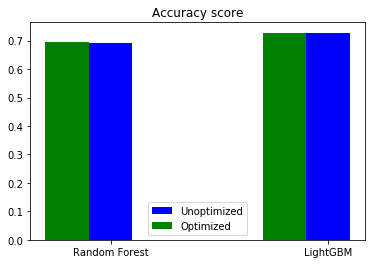

In [118]:
accuracy_pre = {"Random Forest": 0.69157495607139552, "LightGBM": 0.72607047072967723}
accuracy_post = {"Random Forest": 0.6957366133357995, "LightGBM": 0.72778137427170997}

X = np.arange(len(accuracy_pre))
ax = plt.subplot(111)
ax.bar(X, accuracy_pre.values(), width=0.2, color='b')
ax.bar(X-0.2, accuracy_post.values(), width=0.2, color='g')
ax.legend(('Unoptimized','Optimized'))
plt.xticks(X, accuracy_pre.keys())
plt.title("Accuracy score")

plt.show()

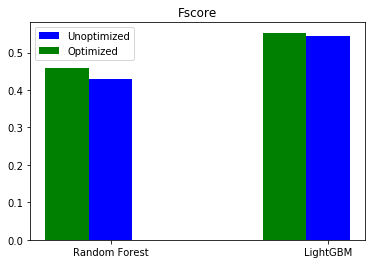

In [119]:
fscore_pre = {"Random Forest": 0.42925026399155231, "LightGBM": 0.54351671678754643}
fscore_post = {"Random Forest": 0.45850066934404288, "LightGBM": 0.55309007232084162}

X = np.arange(len(accuracy_pre))
ax = plt.subplot(111)
ax.bar(X, fscore_pre.values(), width=0.2, color='b')
ax.bar(X-0.2, fscore_post.values(), width=0.2, color='g')
ax.legend(('Unoptimized','Optimized'))
plt.xticks(X, accuracy_pre.keys())
plt.title("Fscore")
plt.show()